In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import albumentations as A

import torch
import zipfile
import contextlib2
import xml.etree.ElementTree as ET

from albumentations.pytorch.transforms import ToTensorV2
from effdet.evaluation.np_box_list import BoxList
from effdet.evaluation.detection_evaluator import PascalDetectionEvaluator
from petrel.dataset import ValDataset
from petrel.predict import model_eval
from torch.utils.data.sampler import SequentialSampler

In [2]:
IMG_SIZE = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
D_SIZE=0
PWD = './Data_Set_Larch_Casebearer'
larch_dirs = [f for f in os.listdir(PWD) if f != '.DS_Store' and 'tf' not in f]

## Load Larch Metadata from XML files.

In [3]:
def xml_to_df(d, directory, filename):
    xml_split = filename.split('/')
    file = xml_split[-1].split('.')[0]
    location, date = directory.split('_')
    root = ET.XML(d)
    objects = []
    for child in root:
        if child.tag == 'object':
            objects.append(child)
        elif child.tag == 'size':
            dims = {s.tag: int(s.text) for s in child}
    
    datas = []
    for child in objects:
        data ={}
        for c in child:
            if c.tag != 'bndbox':
                data[c.tag] = [c.text]
            else:
                for b in c:
                    data[b.tag] = [int(b.text)]
        datas.append(pd.DataFrame(data))
    try:
        df = pd.concat(datas)
        df['height'], df['width'] = dims['height'], dims['width']
        df['location'], df['date'], df['file_name'] = location, int(date), file
    except:
        print(filename)
        df = pd.DataFrame({'height': dims['height'],
                           'width': dims['width'],
                           'location': [location],
                           'date': [int(date)],
                           'file_name': [file]})
    df["file"] = df.apply(lambda row: f"{row['location']}_{row['date']}/Images/{row['file_name']}.JPG", axis=1)
    
    return df

def read_zip(zf):
    z = zipfile.ZipFile(f"{PWD}/{zf}/Annotations.zip", "r")
    df_list = []
    for filename in [f for  f in z.namelist() if "__" not in f and ".xml" in f]:
        with z.open(filename) as f:
            d = f.read() 
            df_list.append(xml_to_df(d, zf, filename))
    
    return pd.concat(df_list).reset_index(drop=True)

In [4]:
%%time
def get_meta_data():
    image_cols = ["location", "file", "file_name", "height", "width"]
    box_cols = ["tree", "damage", "labels", "xmin", "ymin", "xmax", "ymax", "file"]

    ## Concatenate Dataframes from each location into single Dataframe.
    xml_df = pd.concat([read_zip(ld) for ld in larch_dirs]).reset_index(drop=True)
    xml_df['truncated'] = xml_df['truncated'].astype(float)

    ## Standardize column names.
    xml_df.loc[xml_df[~xml_df['name'].isna()].index, 'tree'] = xml_df.loc[
        xml_df[~xml_df['name'].isna()].index,'name']

    ## Drop redundant columns.
    xml_df.drop(columns=['name', 'difficult', 'pose'], inplace=True)

    ## Standardize label for detection of other tree species.
    xml_df.loc[xml_df[xml_df['tree'].isna()].index, 'tree'] = 'Other'
    xml_df['tree'] = xml_df['tree'].apply(lambda t: t.capitalize())\
                                   .apply(lambda t: t if t != 'Spruce' else 'Other')

    ## Remove detections with no damage information.
    xml_df = xml_df[~xml_df['damage'].isnull()].reset_index(drop=True)
    xml_df['truncated'] = xml_df['truncated'].astype(int)
    for col in ["truncated", "xmin", "xmax", "ymin", "ymax"]:
        xml_df[col] = xml_df[col].astype(int)
    damage_map = {d: n + 1 for n, d in enumerate(xml_df["damage"].sort_values().unique())}
    xml_df["labels"] = xml_df["damage"].apply(lambda d: damage_map[d])

    ## Drop duplicate entries.
    xml_df = xml_df.drop_duplicates().reset_index(drop=True)

    ## Separate May and August Data.
    xml_images = xml_df[xml_df['date'] == 20190527][image_cols].drop_duplicates().reset_index(drop=True)
    xml_boxes = xml_df[xml_df['date'] == 20190527][box_cols].reset_index(drop=True)
    xml_august = xml_df[xml_df['date'] == 20190819][image_cols].drop_duplicates().reset_index(drop=True)
    xml_aug_boxes = xml_df[xml_df['date'] == 20190819][box_cols].reset_index(drop=True)


    xml_train = pd.read_csv("xml_train.csv")
    xml_val = pd.read_csv("xml_val.csv")
    xml_val.reset_index(drop=True, inplace=True)
    xml_train_boxes = xml_boxes[xml_boxes["file"].isin(xml_train["file"])].reset_index(drop=True)
    xml_val_boxes = xml_boxes[xml_boxes["file"].isin(xml_val["file"])].reset_index(drop=True)
    return xml_train, xml_val, xml_train_boxes, xml_val_boxes, damage_map

xml_train, xml_val, xml_train_boxes, xml_val_boxes, damage_map = get_meta_data()

Annotations/B04_0181.xml
Annotations/B10_0221.xml
Annotations/B02_0230.xml
CPU times: user 54.9 s, sys: 211 ms, total: 55.1 s
Wall time: 55.3 s


## Load Prediction Data

In [5]:
edet = {d: pd.read_pickle(f"./edet{d}.pickle") for d in range(3)}
categories = [{"id": v, "name": k} for k, v in damage_map.items()]

In [6]:
eval_det = {k: model_eval(v, categories) for k, v in edet.items()}

## PASCAL VOC mAP

In [7]:
for d in eval_det:
    print(f"D{d}")
    print(np.round(eval_det[d] * 100,1))

D0
      Precision     H    HD    LD  other
0.50       75.9  64.1  73.8  90.6   74.9
0.55       75.0  63.9  72.7  89.9   73.5
0.60       73.8  63.6  71.4  88.8   71.3
0.65       71.3  61.8  68.4  86.9   68.0
0.70       66.7  58.3  63.8  82.5   62.3
0.75       57.3  51.5  52.7  72.7   52.2
0.80       41.0  39.3  32.8  54.8   37.3
0.85       20.4  21.0  12.7  27.8   20.3
0.90        4.4   4.7   2.2   5.5    5.4
0.95        0.1   0.1   0.0   0.1    0.1
D1
      Precision     H    HD    LD  other
0.50       79.0  68.1  76.6  92.4   78.7
0.55       78.1  67.2  76.0  91.8   77.2
0.60       76.9  66.6  74.8  90.9   75.3
0.65       74.2  64.2  72.1  88.7   71.9
0.70       69.7  62.8  65.6  84.9   65.7
0.75       60.3  56.7  53.9  75.1   55.6
0.80       43.3  41.1  33.7  58.0   40.5
0.85       21.9  22.4  13.8  29.2   22.2
0.90        4.8   5.2   1.9   6.5    5.8
0.95        0.1   0.0   0.0   0.1    0.3
D2
      Precision     H    HD    LD  other
0.50       77.4  63.1  76.4  92.5   77.6
0.55   

## COCO mAP

In [8]:
for d in eval_det:
    print(f"D{d}")
    print(np.round(eval_det[d].mean() * 100, 1))

D0
Precision    48.6
H            42.8
HD           45.1
LD           60.0
other        46.5
dtype: float64
D1
Precision    50.8
H            45.4
HD           46.9
LD           61.8
other        49.3
dtype: float64
D2
Precision    50.1
H            42.5
HD           46.9
LD           62.2
other        49.0
dtype: float64


## Compute IOU

In [9]:
def area(boxes):
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])


def intersection(boxes1, boxes2):
    [y_min1, x_min1, y_max1, x_max1] = np.split(boxes1, 4, axis=1)
    [y_min2, x_min2, y_max2, x_max2] = np.split(boxes2, 4, axis=1)

    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape), all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape), all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths


def iou(boxes1, boxes2):
    intersect = intersection(boxes1, boxes2)
    area1 = area(boxes1)
    area2 = area(boxes2)
    union = np.expand_dims(area1, axis=1) + np.expand_dims(area2, axis=0) - intersect
    return intersect / union

def iou_boxlist(boxlist1, boxlist2):
    return iou(boxlist1.get(), boxlist2.get())

def get_overlaps_and_scores_box_mode(pred_boxes, pred_scores, gt_boxes):
    pred_boxlist = BoxList(pred_boxes)
    pred_boxlist.add_field('scores', pred_scores)
    iou_boxes = iou_boxlist(pred_boxlist, BoxList(gt_boxes))
    scores = pred_boxlist.get_field('scores')
    num_boxes = pred_boxlist.num_boxes()
    return iou_boxes, scores, num_boxes

## Find True Positives and False Positives

In [10]:
def compute_tp_fp_for_single_class(pred_boxes, pred_scores, gt_boxes,
                                  matching_iou_threshold=0.5):
    if pred_boxes.size == 0:
        return np.array([], dtype=float), np.array([], dtype=bool)

    iou_b, scores, num_detected_boxes = get_overlaps_and_scores_box_mode(
        pred_boxes=pred_boxes,
        pred_scores=pred_scores,
        gt_boxes=gt_boxes)

    if gt_boxes.size == 0:
        return scores, np.zeros(num_detected_boxes, dtype=bool)

    tp_fp_labels = np.zeros(num_detected_boxes, dtype=bool)
    is_matched_to_box = np.zeros(num_detected_boxes, dtype=bool)

    def compute_match_iou(iou_matrix, is_box):
        max_overlap_gt_ids = np.argmax(iou_matrix, axis=1)
        is_gt_detected = np.zeros(iou_matrix.shape[1], dtype=bool)
        for i in range(num_detected_boxes):
            gt_id = max_overlap_gt_ids[i]
            is_evaluatable = not tp_fp_labels[i] and iou_matrix[i, gt_id] >= matching_iou_threshold
            if is_evaluatable and not is_gt_detected[gt_id]:
                tp_fp_labels[i] = True
                is_gt_detected[gt_id] = True
                is_matched_to_box[i] = is_box

    if iou_b.shape[1] > 0:
        compute_match_iou(iou_b, is_box=True)

    scores_box_group_of = np.ndarray([0], dtype=float)
    tp_fp_labels_box_group_of = np.ndarray([0], dtype=float)

    return scores,tp_fp_labels.astype(float)

def compute_tp_fp(pred_boxes,
                  pred_scores,
                  pred_labels,
                  gt_boxes,
                  gt_labels,
                  num_classes):
    result_scores = []
    result_tp_fp_labels = []
    for c in range(1, num_classes + 1):
        class_gt = (gt_labels == c)
        gt_boxes_c = gt_boxes[class_gt]
        class_detections = (pred_labels == c)
        pred_boxes_c = pred_boxes[class_detections]
        pred_scores_c = pred_scores[class_detections]
        scores, tp_fp_labels = compute_tp_fp_for_single_class(
                pred_boxes=pred_boxes_c,
                pred_scores=pred_scores_c,
                gt_boxes=gt_boxes_c)
        result_scores.append(scores)
        result_tp_fp_labels.append(tp_fp_labels)
    return result_scores, result_tp_fp_labels

## Optimal score cutoff for usable detections.

In [11]:
def get_cutoff(df, num_classes, cutoffs=np.round(np.arange(0, 1.001, 0.001), 3)):
    score_dict = {n: [] for n in range(1, 5)}
    tp_fp_dict = {n: [] for n in range(1, 5)}
    for _, row in df.iterrows():
        scores, tp_fp = compute_tp_fp(row['pred_boxes'],
                                      row['pred_scores'],
                                      row['pred_labels'],
                                      row['gt_boxes'],
                                      row['gt_labels'],
                                      num_classes)
        for n in range(1, num_classes+1):
            score_dict[n].append(scores[n - 1])
            tp_fp_dict[n].append(tp_fp[n - 1])
        
    score_dict = {n: np.concatenate(v) for n, v in score_dict.items()}
    tp_fp_dict = {n: np.concatenate(v) for n, v in tp_fp_dict.items()}
    
    precision_dict = {n: np.zeros(cutoffs.size) for n in range(1, 5)}
    recall_dict = {n: np.zeros(cutoffs.size) for n in range(1, 5)}
    f1_dict = {n: np.zeros(cutoffs.size) for n in range(1, 5)}
    gt_labels = np.concatenate(df['gt_labels'])
    label_count = {n: (gt_labels == n).sum() for n in range(1,5)}
    for n in score_dict:
        for i, p in enumerate(cutoffs):
            tp_fp = tp_fp_dict[n][score_dict[n] >= p]
            precision_dict[n][i] = tp_fp.sum()/tp_fp.size if tp_fp.size > 0 else 0
            recall_dict[n][i] = tp_fp.sum()/label_count[n]
        f1_dict[n] = 2 * precision_dict[n] * recall_dict[n]/(precision_dict[n] + recall_dict[n])
        np.nan_to_num(f1_dict[n], copy=False)
    
    arg_cutoff = np.argmax(np.stack(f1_dict.values()).mean(axis=0))
    cutoff = cutoffs[arg_cutoff]
    return cutoff, precision_dict, recall_dict

def predictions_above_cutoff(df, num_classes):
    cutoff, _, _ = get_cutoff(df, num_classes)
    df_cutoff = df.copy()
    df_cutoff['pred_labels'] = df_cutoff.apply(lambda row: row['pred_labels'][row['pred_scores'] >= cutoff],
                                                 axis=1)
    df_cutoff['pred_boxes'] = df_cutoff.apply(lambda row: row['pred_boxes'][row['pred_scores'] >= cutoff],
                                                axis=1)
    df_cutoff['pred_scores'] = df_cutoff.apply(lambda row: row['pred_scores'][row['pred_scores'] >= cutoff],
                                                 axis=1)
    return df_cutoff, cutoff

In [12]:
edet_cutoff, cutoff = {}, {}
for d in edet:
    edet_cutoff[d], cutoff[d] = predictions_above_cutoff(edet[d], 4)

<ipython-input-11-f8b1b3e4de23>:28: RuntimeWarning: invalid value encountered in true_divide
  f1_dict[n] = 2 * precision_dict[n] * recall_dict[n]/(precision_dict[n] + recall_dict[n])
<ipython-input-12-157917d74129>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  edet_cutoff[d], cutoff[d] = predictions_above_cutoff(edet[d], 4)


## Compute Average Recall

In [13]:
def get_ar(df, num_classes, num_detection=None):
    tp_fp_dict = {n + 1: [] for n in range(num_classes)}
    gt = {n + 1: df['gt_labels'].apply(lambda gt: (gt == n + 1).sum()).sum() for n in range(num_classes)}
    for _, row in df.iterrows():
        if num_detection:
            _, tp_fp = compute_tp_fp(row['pred_boxes'][:num_detection],
                                          row['pred_scores'][:num_detection],
                                          row['pred_labels'][:num_detection],
                                          row['gt_boxes'],
                                          row['gt_labels'],
                                          num_classes)
        else:
            _, tp_fp = compute_tp_fp(row['pred_boxes'],
                                          row['pred_scores'],
                                          row['pred_labels'],
                                          row['gt_boxes'],
                                          row['gt_labels'],
                                          num_classes) 
        
        for n in tp_fp_dict:
            tp_fp_dict[n].append(tp_fp[n - 1])
    tp_fp_dict = {n: np.concatenate(v) for n, v in tp_fp_dict.items()}
    return {n: np.round(tp_fp_dict[n].sum()/gt[n] * 100,1) for n in tp_fp_dict}

## AR@100

In [14]:
for d in edet:
    print(d)
    print(get_ar(edet[d], 4, 100))

0
{1: 69.8, 2: 78.9, 3: 89.4, 4: 79.1}
1
{1: 69.8, 2: 79.5, 3: 91.3, 4: 81.4}
2
{1: 65.8, 2: 75.5, 3: 92.8, 4: 81.4}


## AR

In [15]:
for d in edet:
    print(d)
    print(get_ar(edet[d], 4))

0
{1: 89.3, 2: 89.4, 3: 96.1, 4: 87.1}
1
{1: 91.5, 2: 91.3, 3: 97.2, 4: 89.7}
2
{1: 88.3, 2: 90.0, 3: 97.6, 4: 89.1}


## Correlation between mAP and class frequency.

In [16]:
eval_image = {n: {loc: model_eval(edet[n].loc[[loc]].reset_index(drop=True),
           categories) for loc in edet[n].index} for n in edet}

edet = {n: pd.pivot(pd.concat({loc: np.round(eval_image[n][loc].mean() * 100, 2) for loc in eval_image[n]})\
                    .reset_index()\
  .rename(columns={"level_0": "image", 'level_1': "damage", 0: "mAP"}),
        columns='damage', values='mAP', index='image')\
  .merge(edet[n], left_index=True, right_index=True) for n in eval_image}

/Users/dmorton/opt/anaconda3/envs/torch/lib/python3.8/site-packages/effdet/evaluation/metrics.py:106: RuntimeWarning: invalid value encountered in true_divide
  num_images_correctly_detected_per_class / num_gt_imgs_per_class)


In [17]:
for d in edet:
    for n, D in enumerate(np.sort(xml_val_boxes['damage'].unique())):
        edet[d][f"{D}_count"] = edet[d]['gt_labels'].apply(lambda gt: (gt == n + 1).sum())
        edet[d][f"{D}_percent"] = edet[d]['gt_labels'].apply(lambda gt: (gt == n + 1).sum()/gt.size)
for n in np.sort(xml_val_boxes['damage'].unique()):
    print(edet[1][[n, f"{n}_percent"]].corr())

                  H  H_percent
H          1.000000   0.449212
H_percent  0.449212   1.000000
                  HD  HD_percent
HD          1.000000    0.141042
HD_percent  0.141042    1.000000
                  LD  LD_percent
LD          1.000000    0.538017
LD_percent  0.538017    1.000000
                  other  other_percent
other          1.000000       0.300638
other_percent  0.300638       1.000000


In [18]:
for n in np.sort(xml_val_boxes['damage'].unique()):
    print(edet[0][[n, f"{n}_percent"]].corr())

                  H  H_percent
H          1.000000   0.491501
H_percent  0.491501   1.000000
                  HD  HD_percent
HD          1.000000    0.196786
HD_percent  0.196786    1.000000
                  LD  LD_percent
LD          1.000000    0.450064
LD_percent  0.450064    1.000000
                  other  other_percent
other          1.000000       0.391566
other_percent  0.391566       1.000000


## Sample of Image ground truth and predictions.

In [19]:
def get_val_full_transform(d_size):
    """
    Returns a function to perform the standard sequence of preprocessing steps
    for validation data.
    """
    return A.Compose([A.Resize(height=IMG_SIZE[d_size],
                               width=IMG_SIZE[d_size],
                               p=1.0),
                      ToTensorV2(p=1.0)],
                     bbox_params=BBOX,
                     p=1.0)

def collate_fn(batch):
    return tuple(zip(*batch))

In [20]:
BBOX = A.BboxParams(format='pascal_voc',
                    min_area=0,
                    min_visibility=0,
                    label_fields=['labels'])

val_full_dataset0 = ValDataset(
    meta_data=xml_val,
    boxes=xml_val_boxes,
    image_root="./Data_Set_Larch_Casebearer",
    transform=get_val_full_transform(d_size=0),
    train_pipe=True
)

val_full_loader0 = torch.utils.data.DataLoader(
    val_full_dataset0, 
    batch_size=8,
    sampler=SequentialSampler(val_full_dataset0),
    shuffle=False,
    pin_memory=False,
    collate_fn=collate_fn)

val_full_dataset1 = ValDataset(
    meta_data=xml_val,
    boxes=xml_val_boxes,
    image_root="./Data_Set_Larch_Casebearer",
    transform=get_val_full_transform(d_size=1),
    train_pipe=True
)

val_full_loader1 = torch.utils.data.DataLoader(
    val_full_dataset1, 
    batch_size=8,
    sampler=SequentialSampler(val_full_dataset1),
    shuffle=False,
    pin_memory=False,
    collate_fn=collate_fn)

In [21]:
for img0, target0 in val_full_loader0:
    break

for img1, target1 in val_full_loader1:
    break

In [22]:
color_key = {1: (0, 0, 255),
             3: (255, 0, 0),
             2: (0, 0, 0),
             4: (0, 255, 0)}

## Edet0

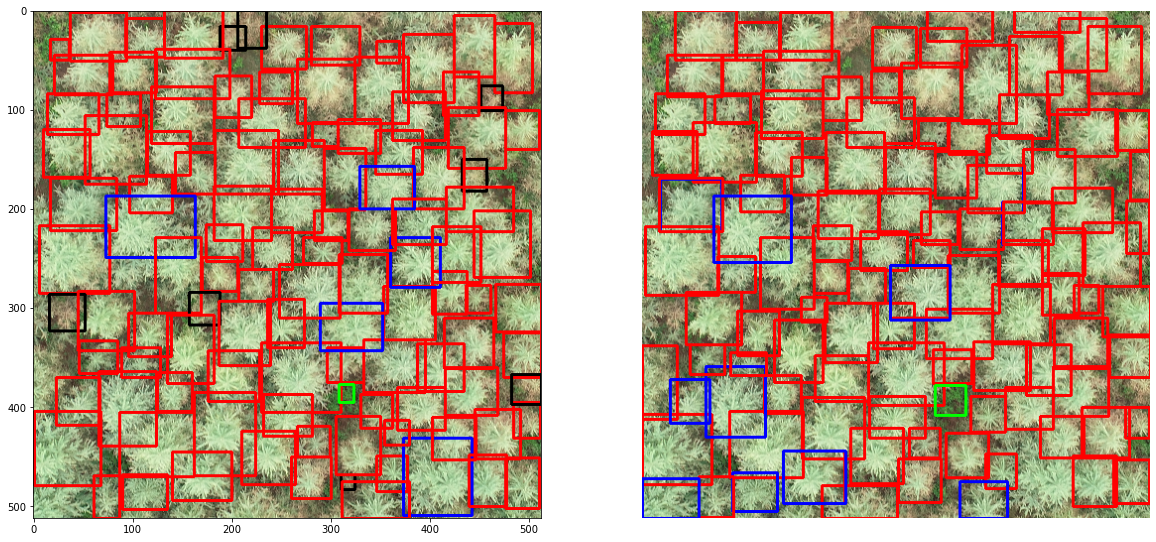

In [23]:
N = 0
_, ax = plt.subplots(1,2, figsize=(20, 20))
plt.axis('off')
image = img0[N].numpy().transpose(1,2,0).copy()
for l, row in zip(target0[N]["labels"], target0[N]["bboxes"]):
    bbox = row.numpy().astype(int)
    cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color_key[int(l)], 2)
ax[0].imshow(image)
image = img0[N].numpy().transpose(1,2,0).copy()
for l, row in zip(edet_cutoff[0].loc[N]['pred_labels'], edet_cutoff[0].loc[N]['pred_boxes']):
    bbox = row.astype(int)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color_key[int(l)], 2)
ax[1].imshow(image)

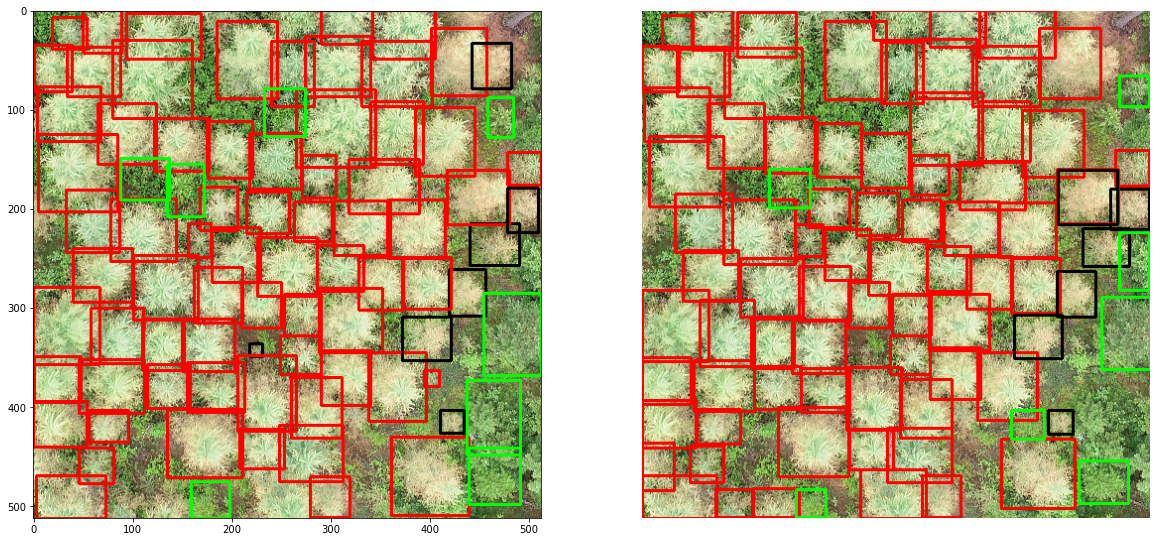

In [24]:
N = 1
_, ax = plt.subplots(1,2, figsize=(20, 20))
plt.axis('off')
image = img0[N].numpy().transpose(1,2,0).copy()
for l, row in zip(target0[N]["labels"], target0[N]["bboxes"]):
    bbox = row.numpy().astype(int)
    cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color_key[int(l)], 2)
ax[0].imshow(image)
image = img0[N].numpy().transpose(1,2,0).copy()
for l, row in zip(edet_cutoff[0].loc[N]['pred_labels'], edet_cutoff[0].loc[N]['pred_boxes']):
    bbox = row.astype(int)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color_key[int(l)], 2)
ax[1].imshow(image)

## Edet 1

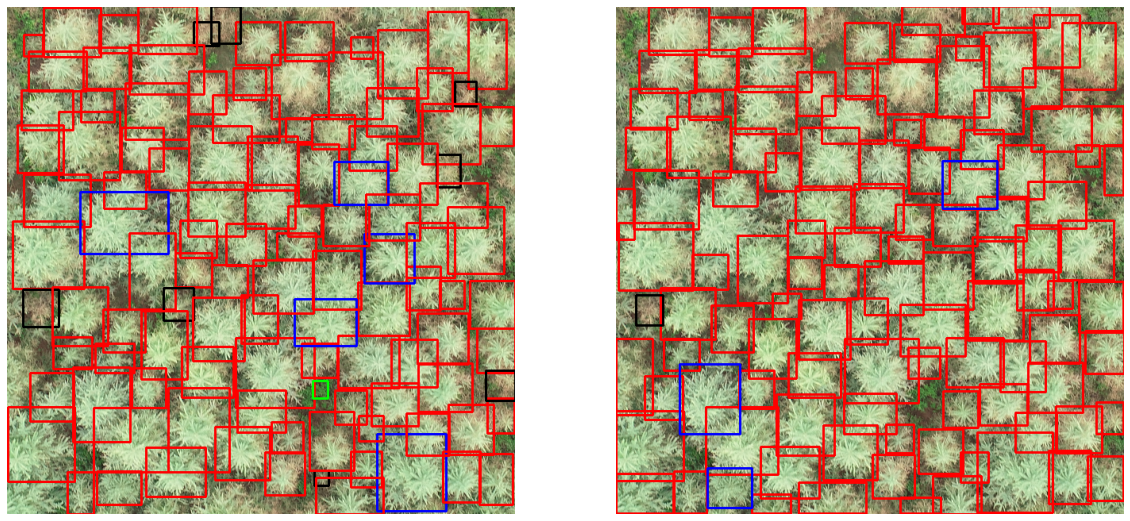

In [25]:
N = 0
_, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].axis('off')
image = img1[N].numpy().transpose(1,2,0).copy()
for l, row in zip(target1[N]["labels"], target1[N]["bboxes"]):
    bbox = row.numpy().astype(int)
    cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color_key[int(l)], 2)
ax[0].imshow(image)
ax[1].axis('off')
image = img1[N].numpy().transpose(1,2,0).copy()
for l, row in zip(edet_cutoff[1].loc[N]['pred_labels'], edet_cutoff[1].loc[N]['pred_boxes']):
    bbox = row.astype(int)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color_key[int(l)], 2)
ax[1].imshow(image)

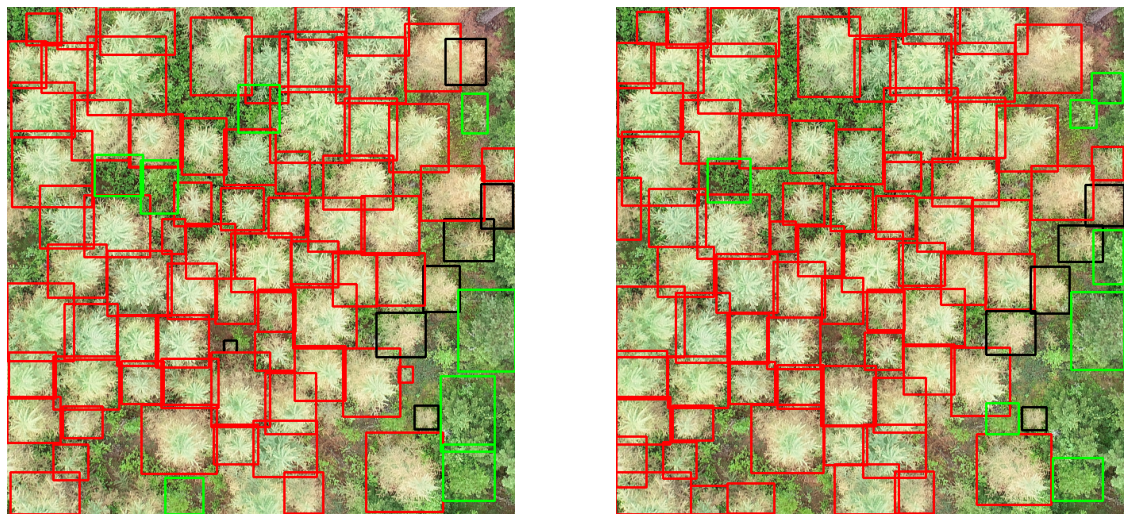

In [26]:
N = 1
_, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].axis('off')
image = img1[N].numpy().transpose(1,2,0).copy()
for l, row in zip(target1[N]["labels"], target1[N]["bboxes"]):
    bbox = row.numpy().astype(int)
    cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color_key[int(l)], 2)
ax[0].imshow(image)
ax[1].axis('off')
image = img1[N].numpy().transpose(1,2,0).copy()
for l, row in zip(edet_cutoff[1].loc[N]['pred_labels'], edet_cutoff[1].loc[N]['pred_boxes']):
    bbox = row.astype(int)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color_key[int(l)], 2)
ax[1].imshow(image)

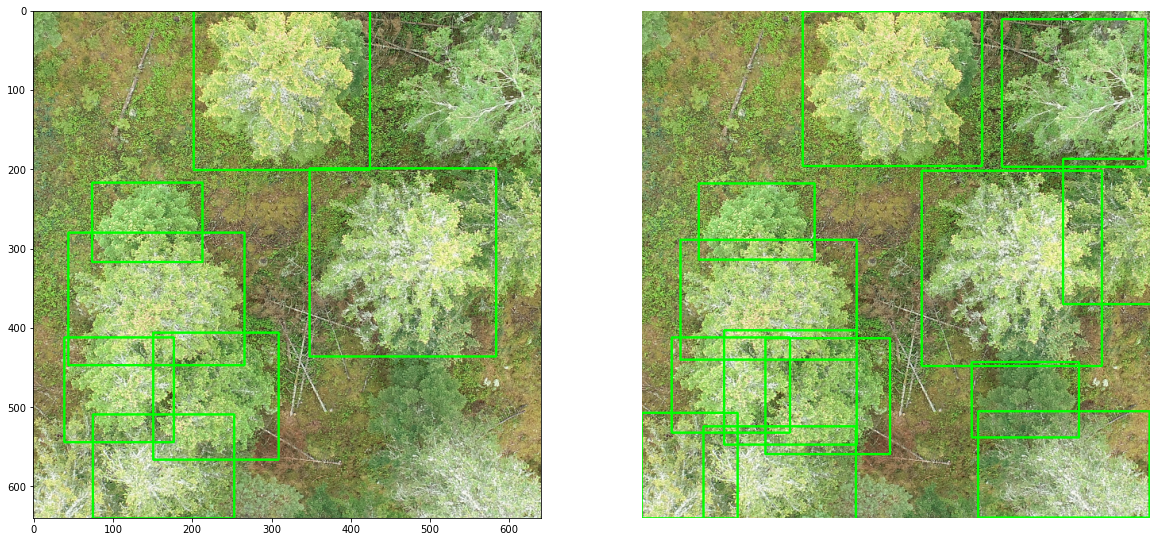

In [27]:
N = 2
_, ax = plt.subplots(1,2, figsize=(20, 20))
plt.axis('off')
image = img1[N].numpy().transpose(1,2,0).copy()
for l, row in zip(target1[N]["labels"], target1[N]["bboxes"]):
    bbox = row.numpy().astype(int)
    cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color_key[int(l)], 2)
ax[0].imshow(image)
image = img1[N].numpy().transpose(1,2,0).copy()
for l, row in zip(edet_cutoff[1].loc[N]['pred_labels'], edet_cutoff[1].loc[N]['pred_boxes']):
    bbox = row.astype(int)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color_key[int(l)], 2)
ax[1].imshow(image)

## Healthy Tree Example

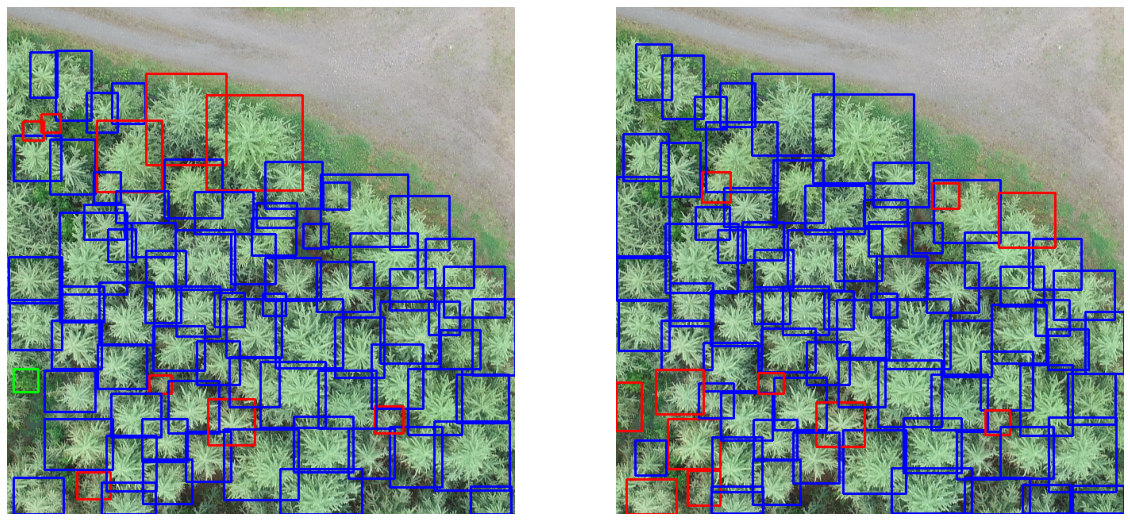

In [28]:
_, ax = plt.subplots(1,2, figsize=(20, 20))
N = 36
ax[0].axis('off')
img, targets = val_full_dataset1.__getitem__(N)
image = img.numpy().transpose(1,2,0).copy()
for l, row in zip(targets["labels"], targets["bboxes"]):
    bbox = row.numpy().astype(int)
    cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color_key[int(l)], 2)
ax[0].imshow(image)
ax[1].axis('off')
image = img.numpy().transpose(1,2,0).copy()
for l, row in zip(edet_cutoff[1].loc[N]['pred_labels'], edet_cutoff[1].loc[N]['pred_boxes']):
    bbox = row.astype(int)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color_key[int(l)], 2)
ax[1].imshow(image)

## High Damage Tree Examples

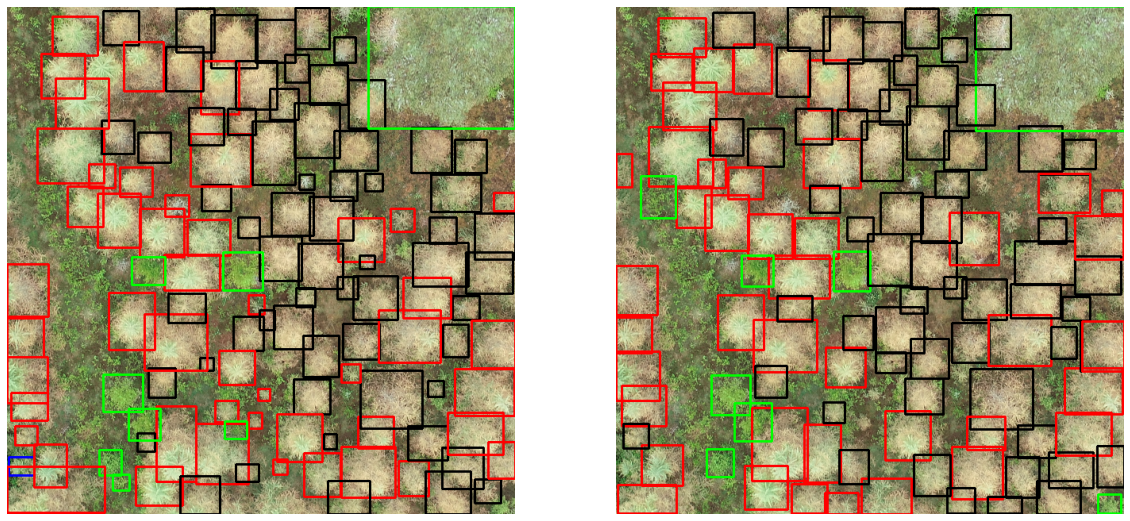

In [29]:
_, ax = plt.subplots(1,2, figsize=(20, 20))
N = 93
ax[0].axis('off')
img, targets = val_full_dataset1.__getitem__(N)
image = img.numpy().transpose(1,2,0).copy()
for l, row in zip(targets["labels"], targets["bboxes"]):
    bbox = row.numpy().astype(int)
    cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color_key[int(l)], 2)
ax[0].imshow(image)
ax[1].axis('off')
image = img.numpy().transpose(1,2,0).copy()
for l, row in zip(edet_cutoff[1].loc[N]['pred_labels'], edet_cutoff[1].loc[N]['pred_boxes']):
    bbox = row.astype(int)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color_key[int(l)], 2)
ax[1].imshow(image)

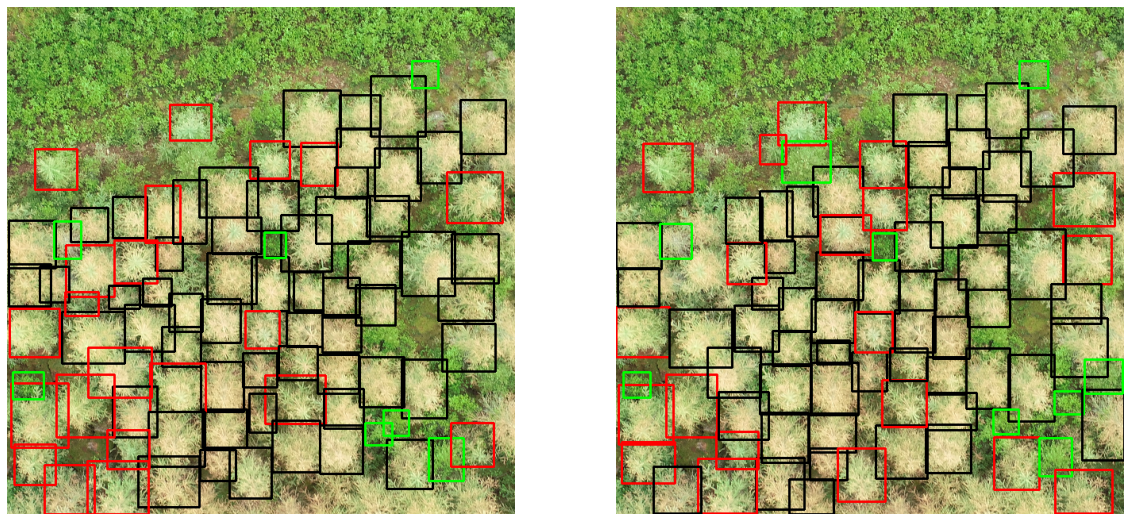

In [30]:
_, ax = plt.subplots(1,2, figsize=(20, 20))
N = 24
ax[0].axis('off')
img, targets = val_full_dataset1.__getitem__(N)
image = img.numpy().transpose(1,2,0).copy()
for l, row in zip(targets["labels"], targets["bboxes"]):
    bbox = row.numpy().astype(int)
    cv2.rectangle(image, (bbox[1], bbox[0]), (bbox[3], bbox[2]), color_key[int(l)], 2)
ax[0].imshow(image)
ax[1].axis('off')
image = img.numpy().transpose(1,2,0).copy()
for l, row in zip(edet_cutoff[1].loc[N]['pred_labels'], edet_cutoff[1].loc[N]['pred_boxes']):
    bbox = row.astype(int)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color_key[int(l)], 2)
ax[1].imshow(image)